In [182]:
import glob
import os
import numpy as np
import pandas as pd
import scanpy as sc
import scvi
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
import random
import matplotlib.pyplot as plt
import seaborn as sns

sc.settings.n_jobs = 12
sc.settings.set_figure_params(dpi=100, frameon=False, figsize=(5,5))

# Pre-process the reference data (DRG)

In [351]:
drg_adata = sc.read_loom('/Users/pax/OneDrive - Karolinska Institutet/PhD/10x_multi_DRG/computation/l1_drg.loom')
drg_adata.obs_names_make_unique()
drg_adata.var_names_make_unique()

/Users/pax/conda3/envs/scvi-env/lib/python3.9/site-packages/anndata/_io/read.py:152: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  axis_df[k] = v
/Users/pax/conda3/envs/scvi-env/lib/python3.9/site-packages/anndata/_io/read.py:152: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  axis_df[k] = v
/Users/pax/conda3/envs/scvi-env/lib/python3.9/site-packages/anndata/_io/read.py:152: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider j

In [352]:
drg_adata.obsm['X_tsne'] = np.vstack((drg_adata.obs['_tSNE1'].to_numpy(), drg_adata.obs['_tSNE2'].to_numpy())).T
drg_adata.obsm['X_scatter'] = np.vstack((drg_adata.obs['_X'].to_numpy(), drg_adata.obs['_Y'].to_numpy())).T

In [353]:
sc.pp.filter_genes(drg_adata, min_cells=100)
drg_adata.layers['counts'] = drg_adata.X.toarray().copy()
sc.pp.normalize_total(drg_adata, target_sum=1e4)
sc.pp.log1p(drg_adata)

/Users/pax/conda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


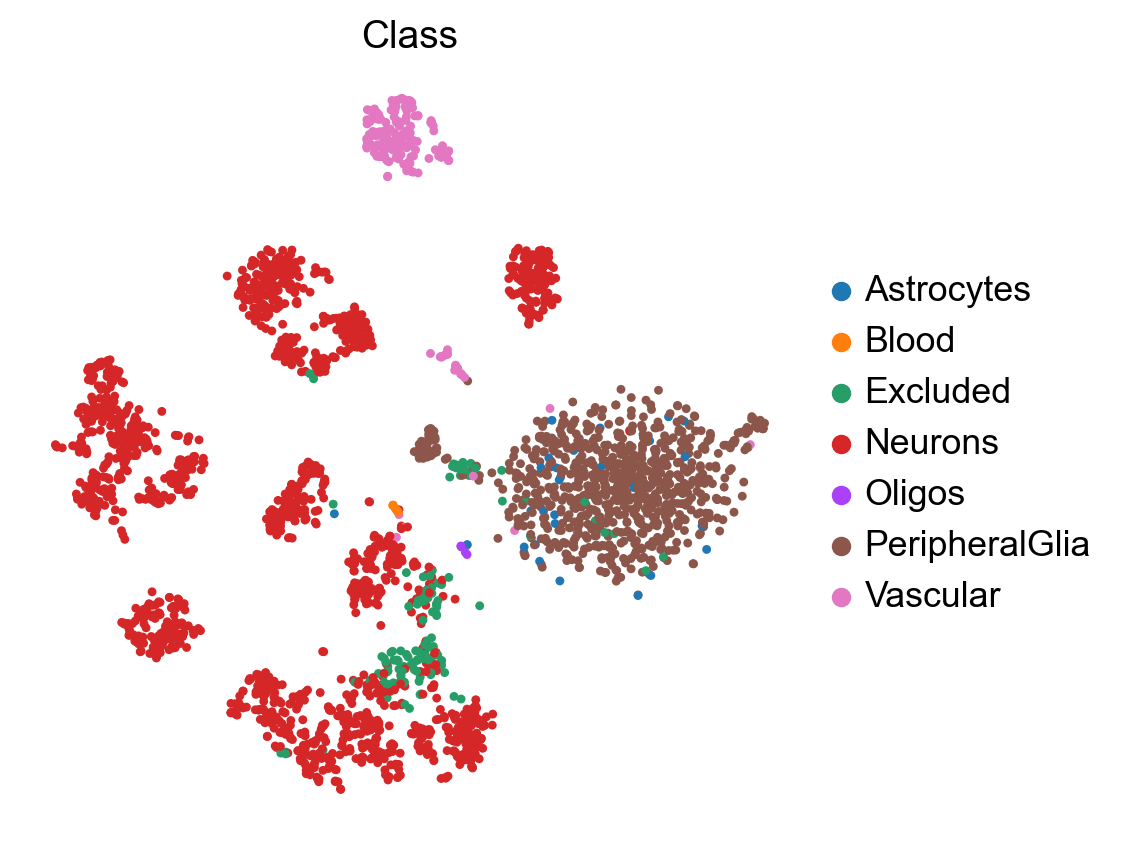

In [354]:
sc.pl.embedding(drg_adata, basis='scatter', color='Class')

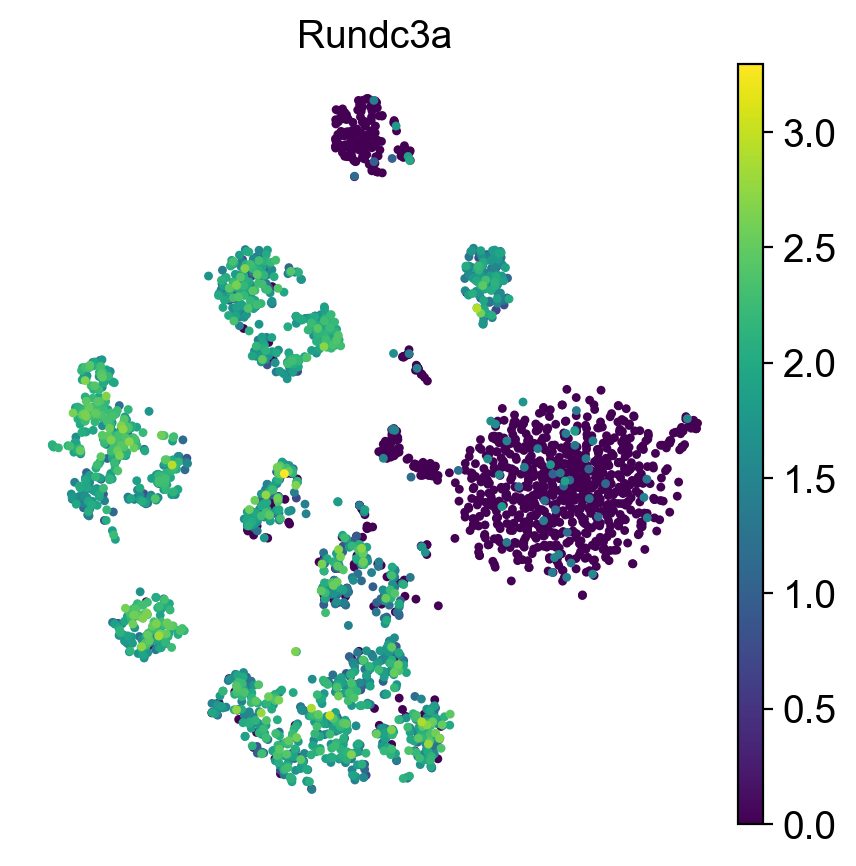

In [355]:
sc.pl.embedding(drg_adata, basis='scatter', color='Rundc3a')

In [356]:
CT_code = dict(zip(drg_adata.obs.Class.cat.categories, range(len(drg_adata.obs.Class.cat.categories))))

In [357]:
drg_adata.obs["Class_num"] = drg_adata.obs.Class.map(CT_code)

In [358]:
y = drg_adata.obs["Class_num"]

In [359]:
sel = RandomForestClassifier(n_jobs=14, n_estimators=100)
sel.fit(drg_adata.X, y)

RandomForestClassifier(n_jobs=14)

In [360]:
pd.DataFrame(sel.feature_importances_, index=drg_adata.var_names).sort_values(0, ascending=False)

0
Gene            
Dbi     0.017307
Bex2    0.017050
Ywhah   0.015742
Sparc   0.013157
Rgcc    0.012330
...          ...
Asb6    0.000000
Mul1    0.000000
Mum1    0.000000
Dolpp1  0.000000
Pdgfrl  0.000000

[10595 rows x 1 columns]

# Pre-process the query data

In [270]:
dir_list = sorted(glob.glob('/Users/pax/OneDrive - Karolinska Institutet/PhD/10x_multi_DRG/data/GEX/*_gex'))
dir_names = sorted(os.listdir('/Users/pax/OneDrive - Karolinska Institutet/PhD/10x_multi_DRG/data/GEX/')[1:])
ids = [name.split('_')[1] for name in dir_names]

In [52]:
adatas = [sc.read_10x_mtx(f"{i}/outs/SoupX") for i in dir_list]

for idx, adata in enumerate(adatas):
    adata.var_names_make_unique()
    adata.obs['Batch_id'] = ids[idx]

In [53]:
adatas[0].obs['conditions'] = 'mutant'
adatas[0].obs['side'] = 'ipsi'

adatas[1].obs['conditions'] = 'mutant'
adatas[1].obs['side'] = 'contra'

adatas[2].obs['conditions'] = 'control'
adatas[2].obs['side'] = 'ipsi'

adatas[3].obs['conditions'] = 'control'
adatas[3].obs['side'] = 'contra'

In [54]:
for adata in adatas:
    sc.pp.filter_cells(adata, min_genes=200)
    sc.pp.filter_genes(adata, min_cells=3)
    adata.var['mt'] = adata.var_names.str.startswith('mt-')  # annotate the group of mitochondrial genes as 'mt'
    sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
    # sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], jitter=0.4, multi_panel=True)

In [55]:
adata = sc.AnnData.concatenate(*adatas)

/Users/pax/conda3/envs/scvi-env/lib/python3.9/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


In [56]:
sc.pp.highly_variable_genes(adata, n_top_genes=1500, subset=True, flavor='seurat_v3', batch_key='batch')

## Train scVI model (VAE) for SOLO to identify doublets

In [57]:
scvi.model.SCVI.setup_anndata(adata, batch_key='batch')

vae = scvi.model.SCVI(adata)
vae.train()

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/pax/conda3/envs/scvi-env/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1789: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(


Epoch 400/400: 100%|██████████| 400/400 [06:48<00:00,  1.20it/s, loss=361, v_num=1]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [06:48<00:00,  1.02s/it, loss=361, v_num=1]


In [58]:
solo = {}

for i in adata.obs.batch.unique():
    solo[i] = scvi.external.SOLO.from_scvi_model(vae, restrict_to_batch=i, adata=adata[adata.obs["batch"] == i].copy())
    solo[i].train()

INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        
INFO     Creating doublets, preparing SOLO model.                                                                  


/Users/pax/conda3/envs/scvi-env/lib/python3.9/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/pax/conda3/envs/scvi-env/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1789: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(


Epoch 293/400:  73%|███████▎  | 293/400 [00:11<00:04, 25.52it/s, loss=0.369, v_num=1]
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.455. Signaling Trainer to stop.
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        
INFO     Creating doublets, preparing SOLO model.                                                                  


/Users/pax/conda3/envs/scvi-env/lib/python3.9/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/pax/conda3/envs/scvi-env/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1789: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(


Epoch 285/400:  71%|███████▏  | 285/400 [00:08<00:03, 35.20it/s, loss=0.317, v_num=1]
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.451. Signaling Trainer to stop.
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        
INFO     Creating doublets, preparing SOLO model.                                                                  


/Users/pax/conda3/envs/scvi-env/lib/python3.9/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/pax/conda3/envs/scvi-env/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1789: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(


Epoch 255/400:  64%|██████▍   | 255/400 [00:13<00:07, 19.42it/s, loss=0.347, v_num=1]
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.396. Signaling Trainer to stop.
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        
INFO     Creating doublets, preparing SOLO model.                                                                  


/Users/pax/conda3/envs/scvi-env/lib/python3.9/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/pax/conda3/envs/scvi-env/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1789: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(


Epoch 385/400:  96%|█████████▋| 385/400 [00:20<00:00, 18.34it/s, loss=0.373, v_num=1]
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.356. Signaling Trainer to stop.


In [59]:
solo_dict = {}

for i in adata.obs.batch.unique():
    solo_dict[i] = solo[i].predict()
    solo_dict[i]['predicted'] = solo[i].predict(soft = False)

In [60]:
solo_df = pd.concat(solo_dict.values())
solo_df.index = solo_df.index.map(lambda x: x[:-2])

solo_df

doublet   singlet predicted
AAACAGCCAAACGCGA-1-0 -0.129727 -0.487129   doublet
AAACAGCCATTTAAGC-1-0 -2.674583  2.672534   singlet
AAACCAACATTATGCG-1-0 -2.342235  2.584927   singlet
AAACGGATCCTAACGG-1-0 -1.377687  1.388672   singlet
AAAGCAAGTTACGCGG-1-0 -0.995762  0.924039   singlet
...                        ...       ...       ...
TTTGTGAAGCTGCACA-1-3  0.550965  0.055729   doublet
TTTGTGGCAGCGCTTG-1-3 -0.311260  0.424772   singlet
TTTGTGTTCACAGCGC-1-3 -1.281453  1.085763   singlet
TTTGTTGGTGGGTGAA-1-3 -3.105592  2.780389   singlet
TTTGTTGGTGTGTGGT-1-3 -2.429265  2.186058   singlet

[4257 rows x 3 columns]

In [61]:
solo_df.groupby('predicted').count()

doublet  singlet
predicted                  
doublet       1349     1349
singlet       2908     2908

In [62]:
solo_df['dif'] = solo_df.doublet - solo_df.singlet
solo_df

doublet   singlet predicted       dif
AAACAGCCAAACGCGA-1-0 -0.129727 -0.487129   doublet  0.357402
AAACAGCCATTTAAGC-1-0 -2.674583  2.672534   singlet -5.347117
AAACCAACATTATGCG-1-0 -2.342235  2.584927   singlet -4.927162
AAACGGATCCTAACGG-1-0 -1.377687  1.388672   singlet -2.766360
AAAGCAAGTTACGCGG-1-0 -0.995762  0.924039   singlet -1.919801
...                        ...       ...       ...       ...
TTTGTGAAGCTGCACA-1-3  0.550965  0.055729   doublet  0.495236
TTTGTGGCAGCGCTTG-1-3 -0.311260  0.424772   singlet -0.736032
TTTGTGTTCACAGCGC-1-3 -1.281453  1.085763   singlet -2.367216
TTTGTTGGTGGGTGAA-1-3 -3.105592  2.780389   singlet -5.885981
TTTGTTGGTGTGTGGT-1-3 -2.429265  2.186058   singlet -4.615323

[4257 rows x 4 columns]

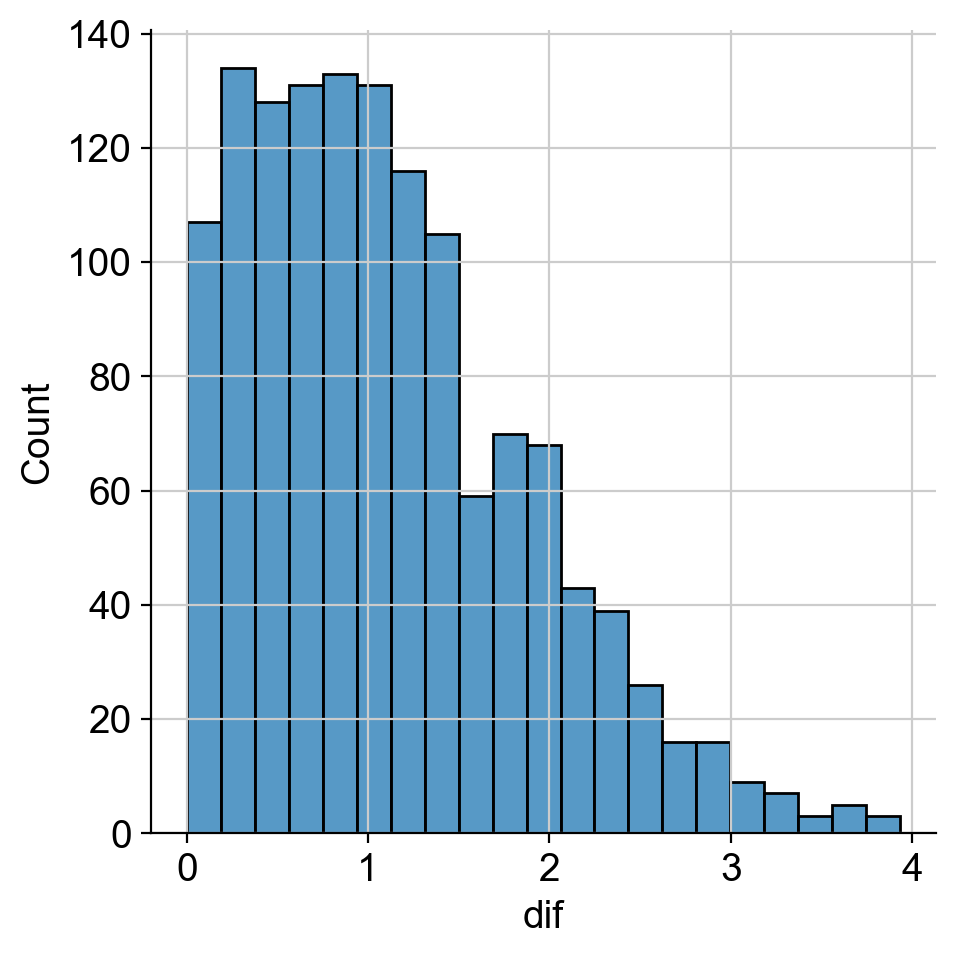

In [63]:
sns.displot(solo_df[solo_df.predicted == 'doublet'], x='dif')

In [67]:
doublet = solo_df[(solo_df.predicted == 'doublet') & (solo_df.dif > 1)]

doublet

doublet   singlet predicted       dif
AAAGCCCGTCATGCCC-1-0  0.501207 -0.517238   doublet  1.018446
AAAGGACGTTAACAGT-1-0  0.103034 -1.122693   doublet  1.225728
AACAGGATCAAACCTA-1-0  0.770750 -0.899867   doublet  1.670617
AACCTTGCACGTAAGG-1-0  0.030593 -1.896937   doublet  1.927530
AACGGTAAGTCACTCC-1-0  0.562291 -0.456447   doublet  1.018738
...                        ...       ...       ...       ...
TTGCGTCTCCTGGCTT-1-3  1.111989 -0.685510   doublet  1.797499
TTGCTTTAGCCTCTGT-1-3  1.040821 -0.050376   doublet  1.091197
TTGTGAGGTTATTGCC-1-3  1.142528 -1.129009   doublet  2.271537
TTTAGCAAGGAACCAA-1-3  0.215863 -0.816835   doublet  1.032697
TTTCATCAGTTTCCTG-1-3  1.029995 -0.663318   doublet  1.693313

[667 rows x 4 columns]

## Remove doublets and normalize the query data

In [361]:
adata = sc.AnnData.concatenate(*adatas)

/Users/pax/conda3/envs/scvi-env/lib/python3.9/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


In [362]:
adata.obs['conditions_side'] = adata.obs.conditions.astype(str) + '_' + adata.obs.side.astype(str)
adata.obs['doublet'] = adata.obs_names.isin(doublet.index)
adata = adata[adata.obs.doublet == False]

In [363]:
adata.layers['counts'] = adata.X.toarray().copy()
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata

# Align the features between ref and query before prediction

In [364]:
var_adata = sc.concat((drg_adata, adata))
sc.pp.highly_variable_genes(var_adata, n_top_genes=1500, subset=True)

/Users/pax/conda3/envs/scvi-env/lib/python3.9/site-packages/anndata/_core/merge.py:942: UserWarning: Only some AnnData objects have `.raw` attribute, not concatenating `.raw` attributes.
  warn(


In [365]:
var_names =  var_adata.var_names

In [366]:
drg_adata = drg_adata[:,var_names]
adata = adata[:,var_names]

# Train the Random Forest model and use the model to predict celltypes in the query

In [367]:
y = drg_adata.obs["Class_num"]
sel = RandomForestClassifier(n_jobs=14, n_estimators=80)
sel.fit(drg_adata.X, y)

RandomForestClassifier(n_estimators=80, n_jobs=14)

In [368]:
adata.obs['predicted'] = sel.predict(adata.X)

/var/folders/pg/_gfvzhnj3zxc0lm8r3cm3jc00000gn/T/ipykernel_90900/4251265549.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['predicted'] = sel.predict(adata.X)


In [369]:
code_to_CT = dict(zip(range(len(drg_adata.obs.Class.cat.categories)), drg_adata.obs.Class.cat.categories))

In [370]:
adata.obs['predicted_CellType'] = adata.obs['predicted'].map(code_to_CT)

In [371]:
adata.obs['predicted_CellType'].unique()

array(['Neurons', 'Vascular', 'PeripheralGlia', 'Excluded', 'Blood'],
      dtype=object)

# Visualize the prediction on UMAP

In [372]:
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])
sc.tl.pca(adata)

In [373]:
sc.pp.neighbors(adata, n_neighbors=50, use_rep='X_pca', n_pcs=40)
sc.tl.leiden(adata, resolution=0.5)
sc.tl.umap(adata, min_dist=0.4)

/Users/pax/conda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/pax/conda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


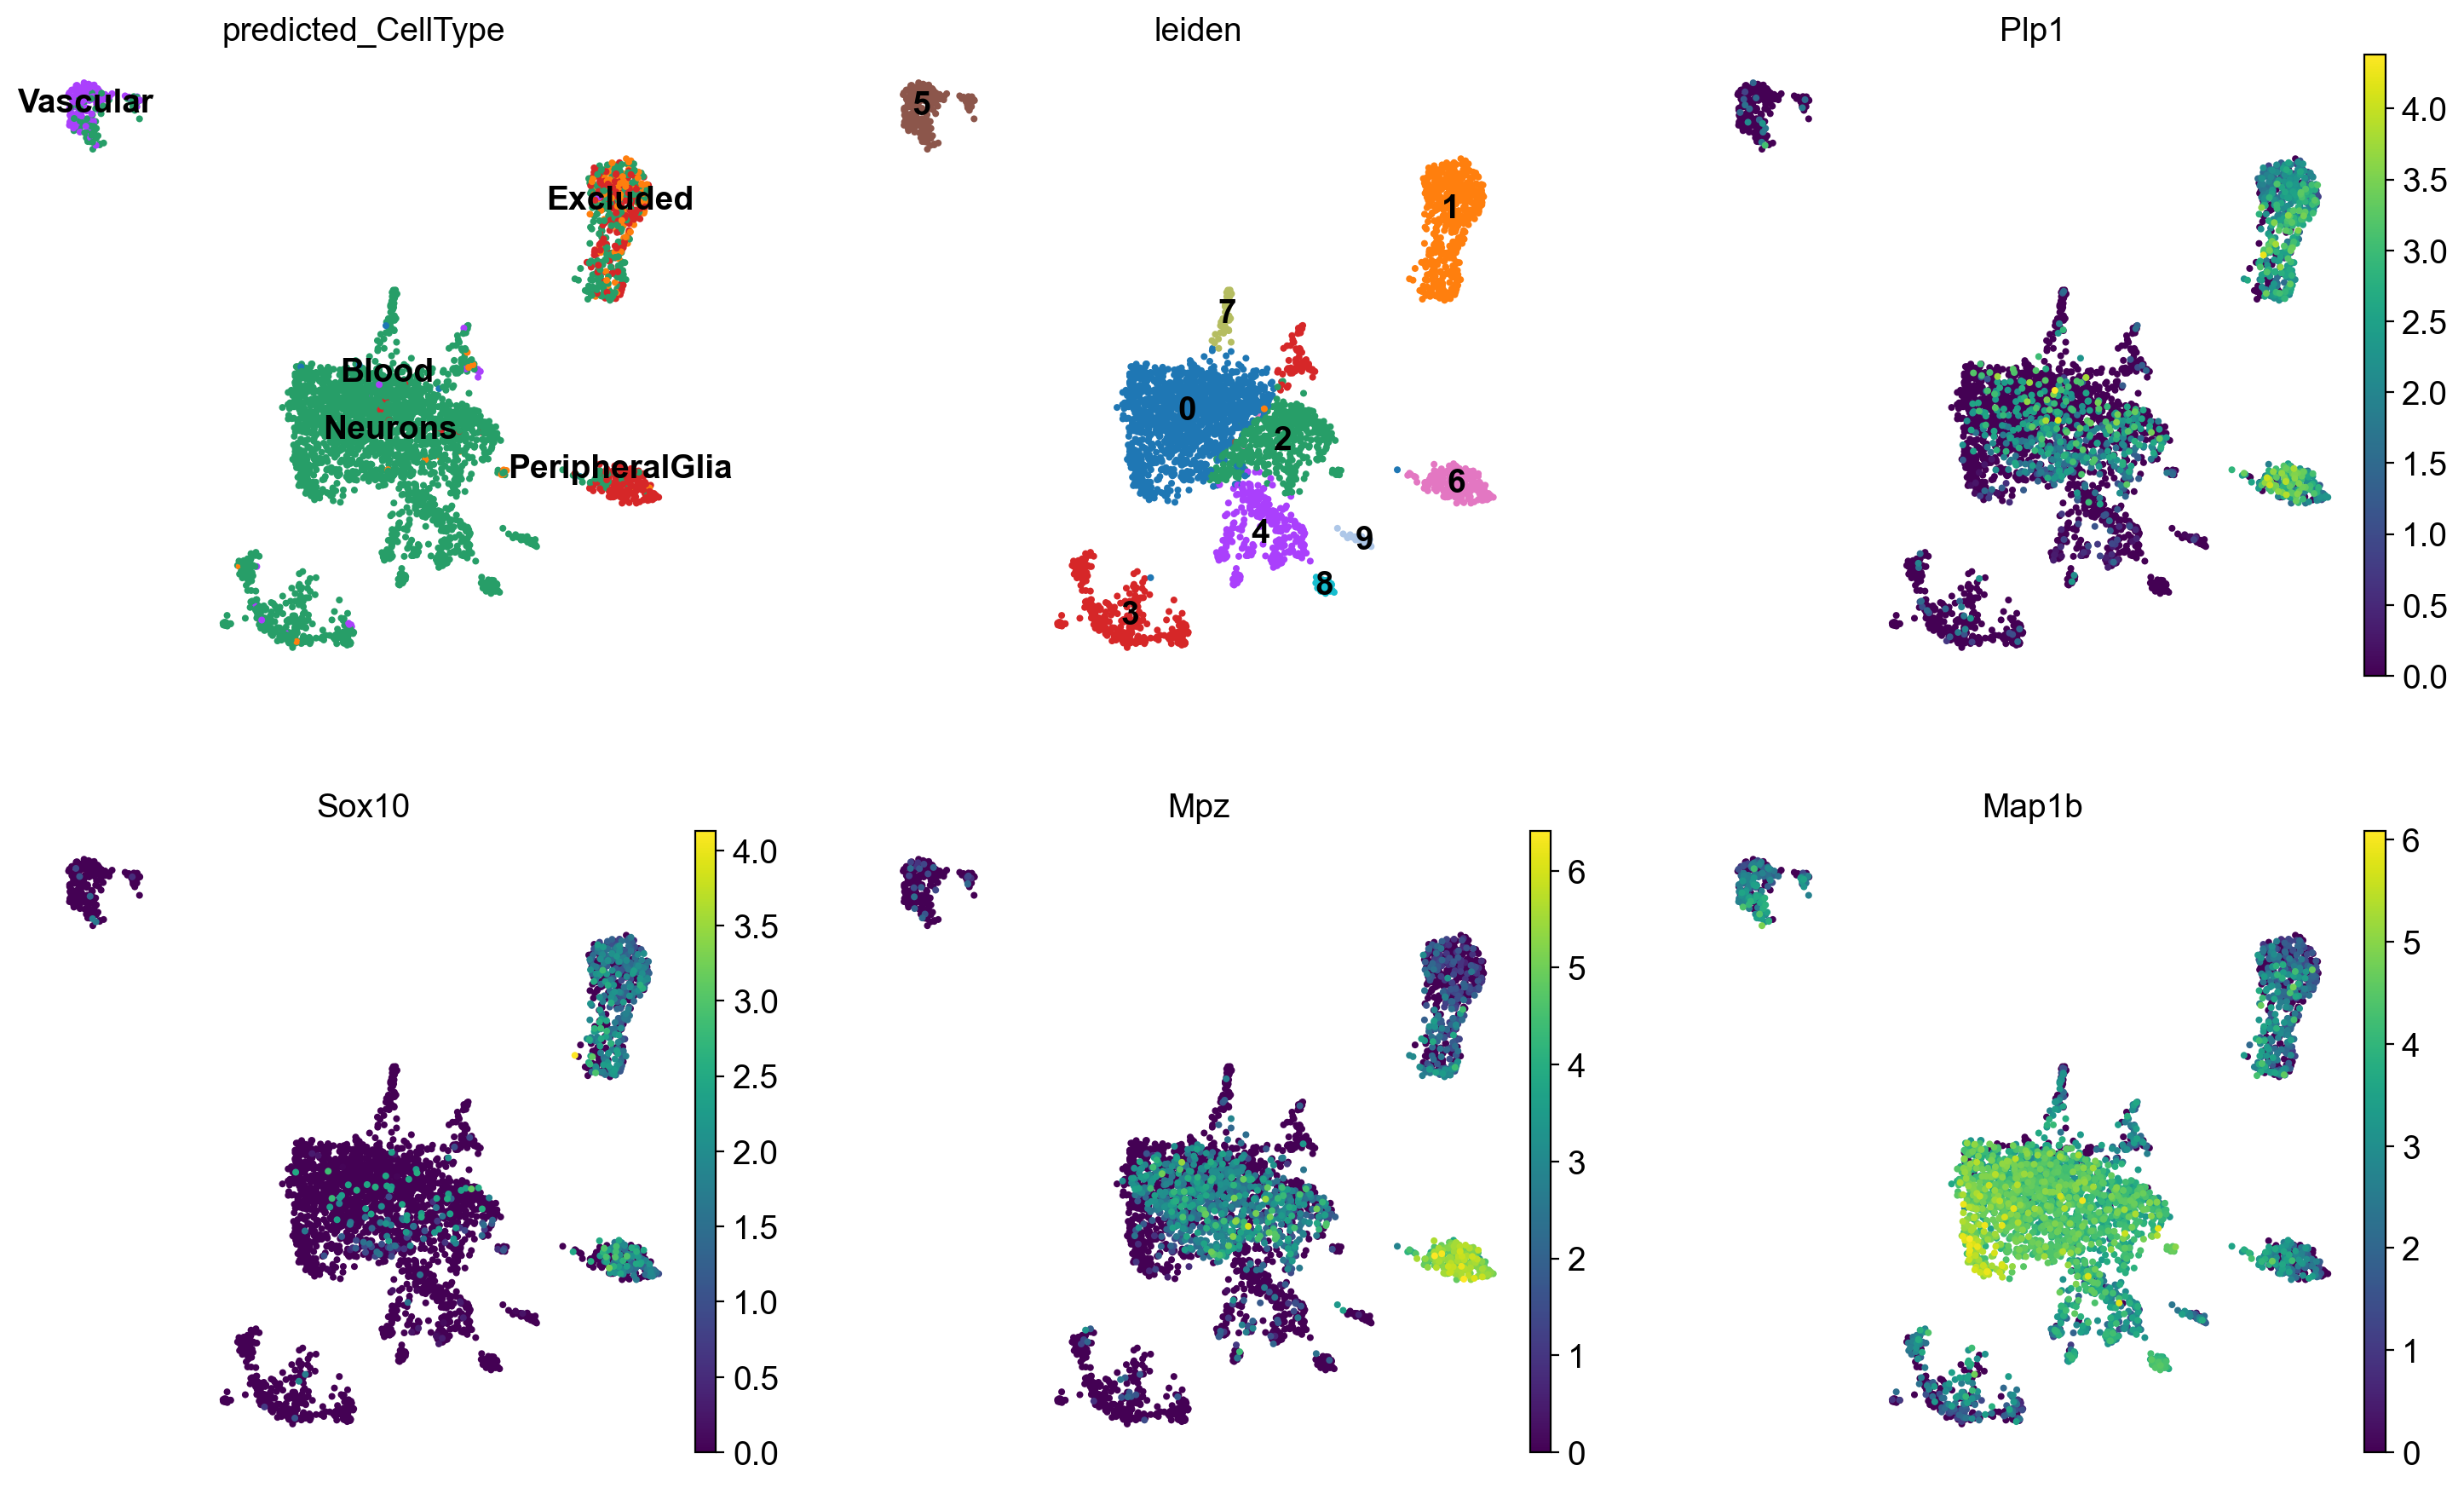

In [374]:
sc.pl.umap(adata, color=['predicted_CellType', 'leiden', 'Plp1', 'Sox10', 'Mpz','Map1b'], ncols=3, legend_loc='on data')

# Subset leiden clusters of Neurons

In [375]:
adata_neurons = adata[~adata.obs.leiden.isin(['1','5','6'])].copy()

In [376]:
sc.tl.pca(adata_neurons)
sc.pp.neighbors(adata_neurons, n_neighbors=50, use_rep='X_pca', n_pcs=40)
sc.tl.leiden(adata_neurons, resolution=0.5)
sc.tl.umap(adata_neurons, min_dist=0.4)

/Users/pax/conda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/pax/conda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/pax/conda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


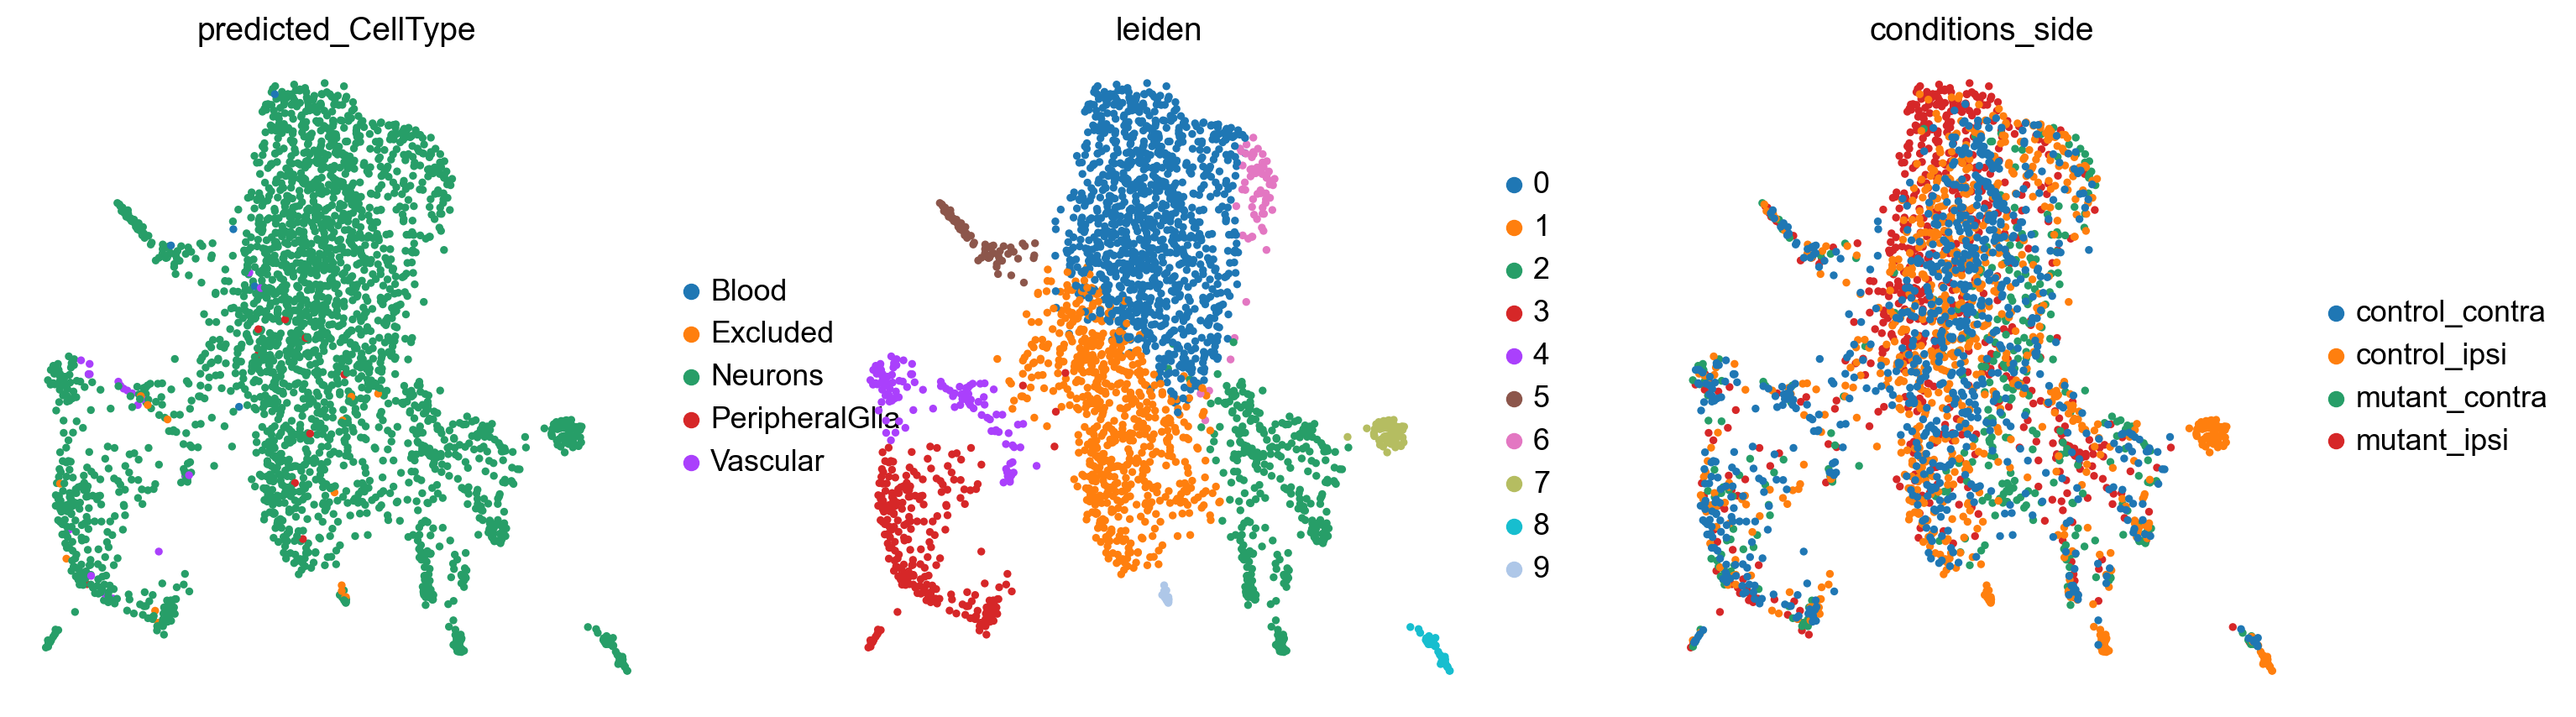

In [377]:
sc.pl.umap(adata_neurons, color=['predicted_CellType', 'leiden', 'conditions_side'], ncols=3)

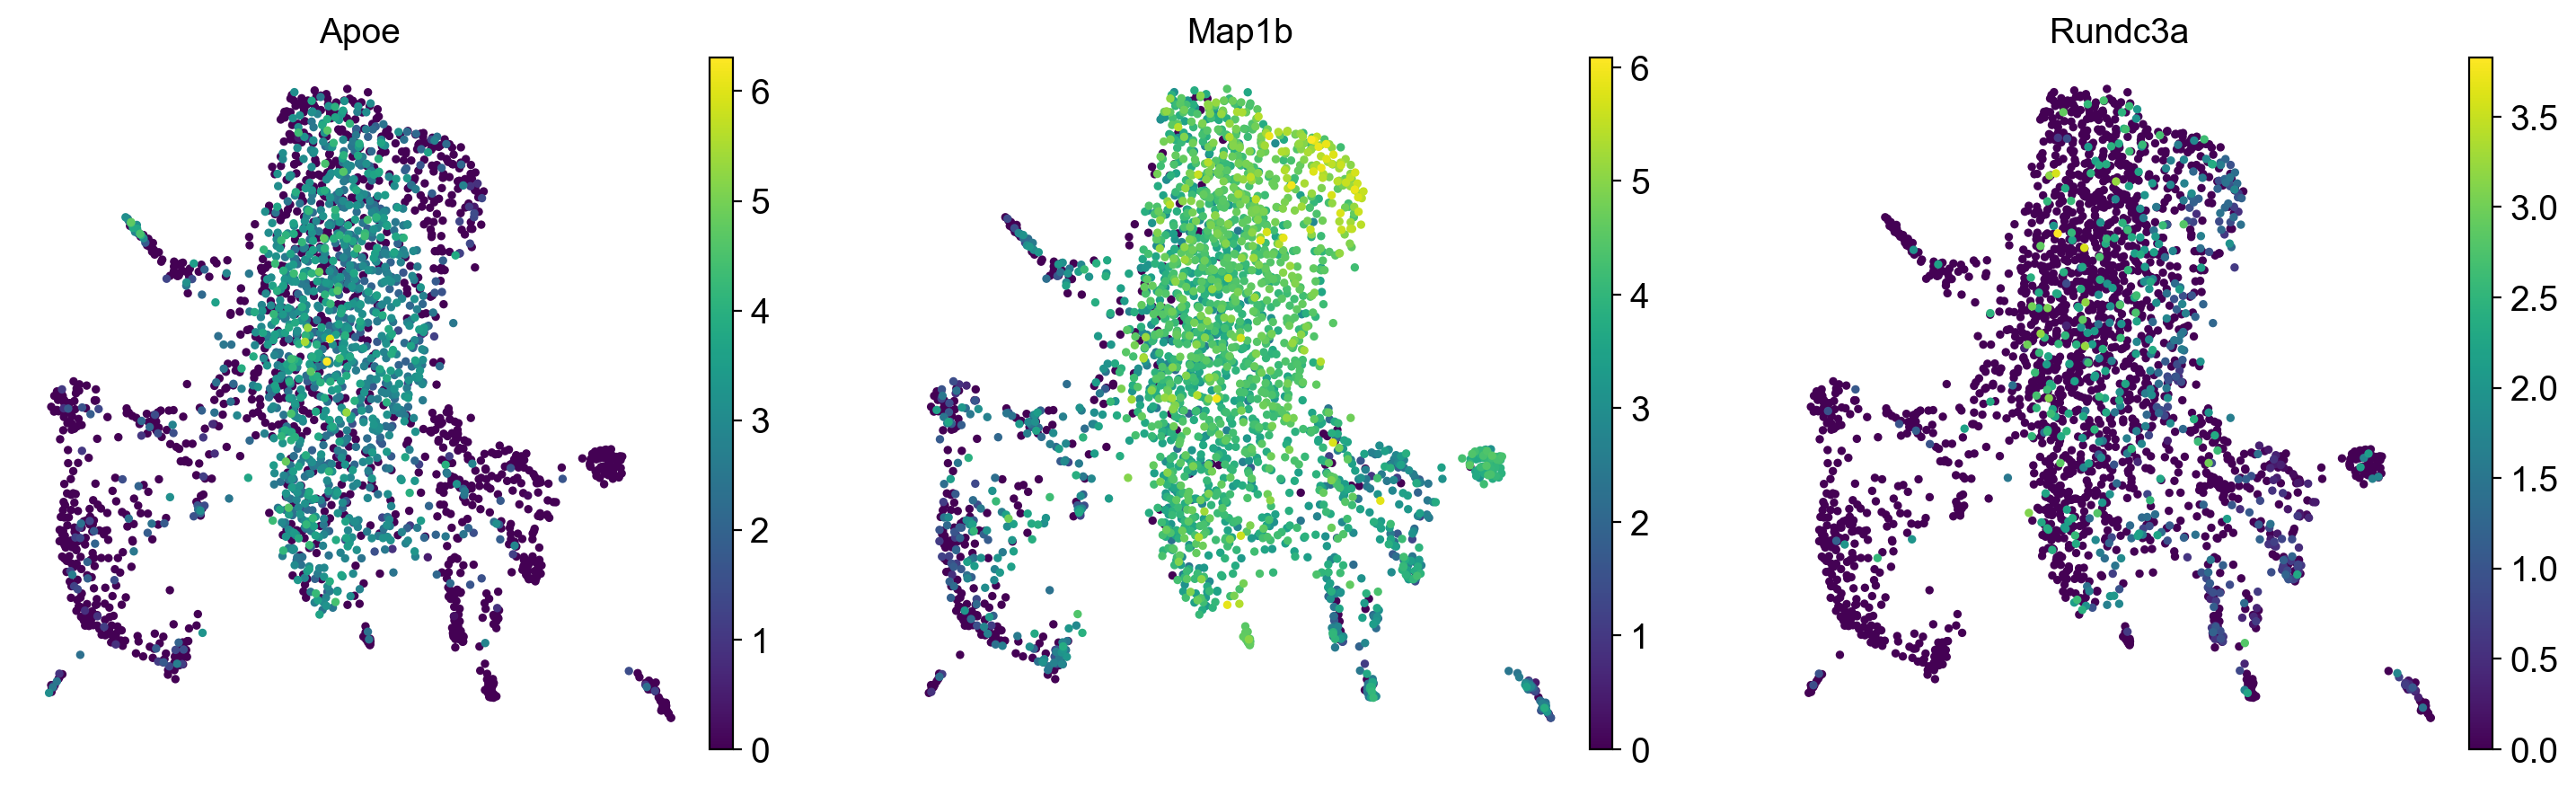

In [378]:
sc.pl.umap(adata_neurons, color=['Apoe', 'Map1b', 'Rundc3a'], ncols=3)

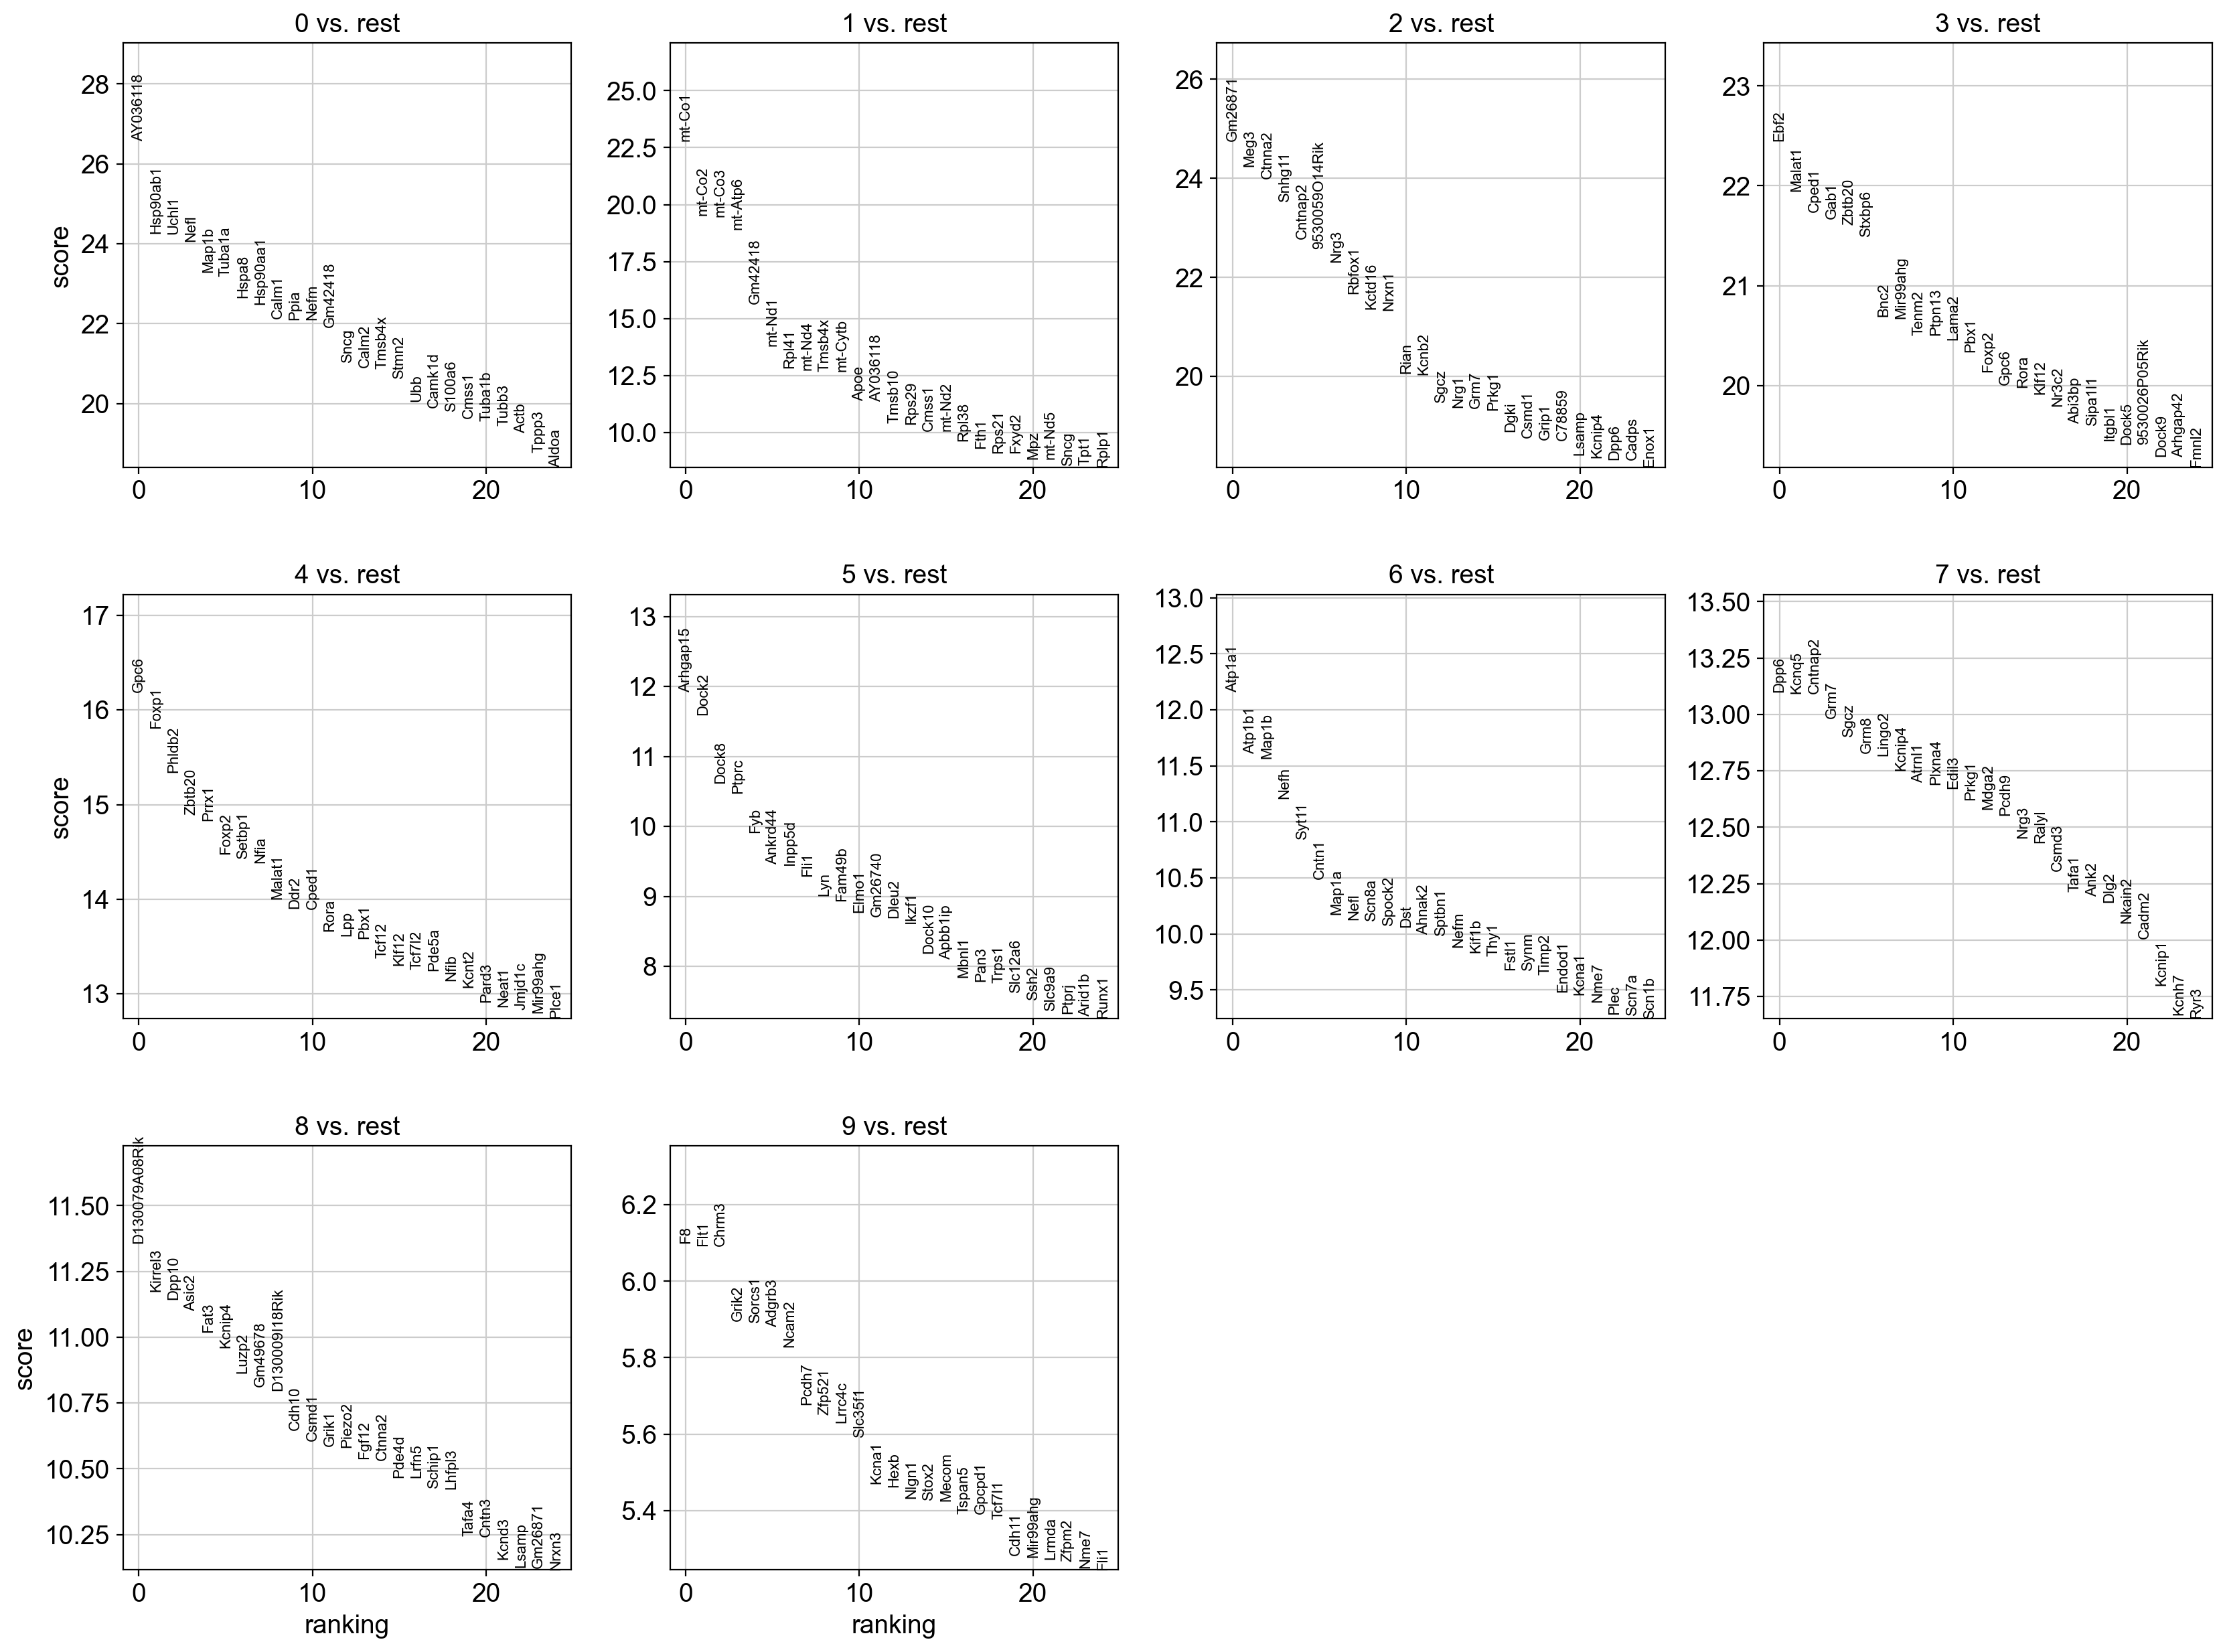

In [379]:
sc.tl.rank_genes_groups(adata_neurons, 'leiden', method='wilcoxon', corr_method='bonferroni', use_raw=True)
sc.pl.rank_genes_groups(adata_neurons, n_genes=25, sharey=False)

/Users/pax/conda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_anndata.py:2414: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  obs_tidy.index.value_counts(sort=False).iteritems()


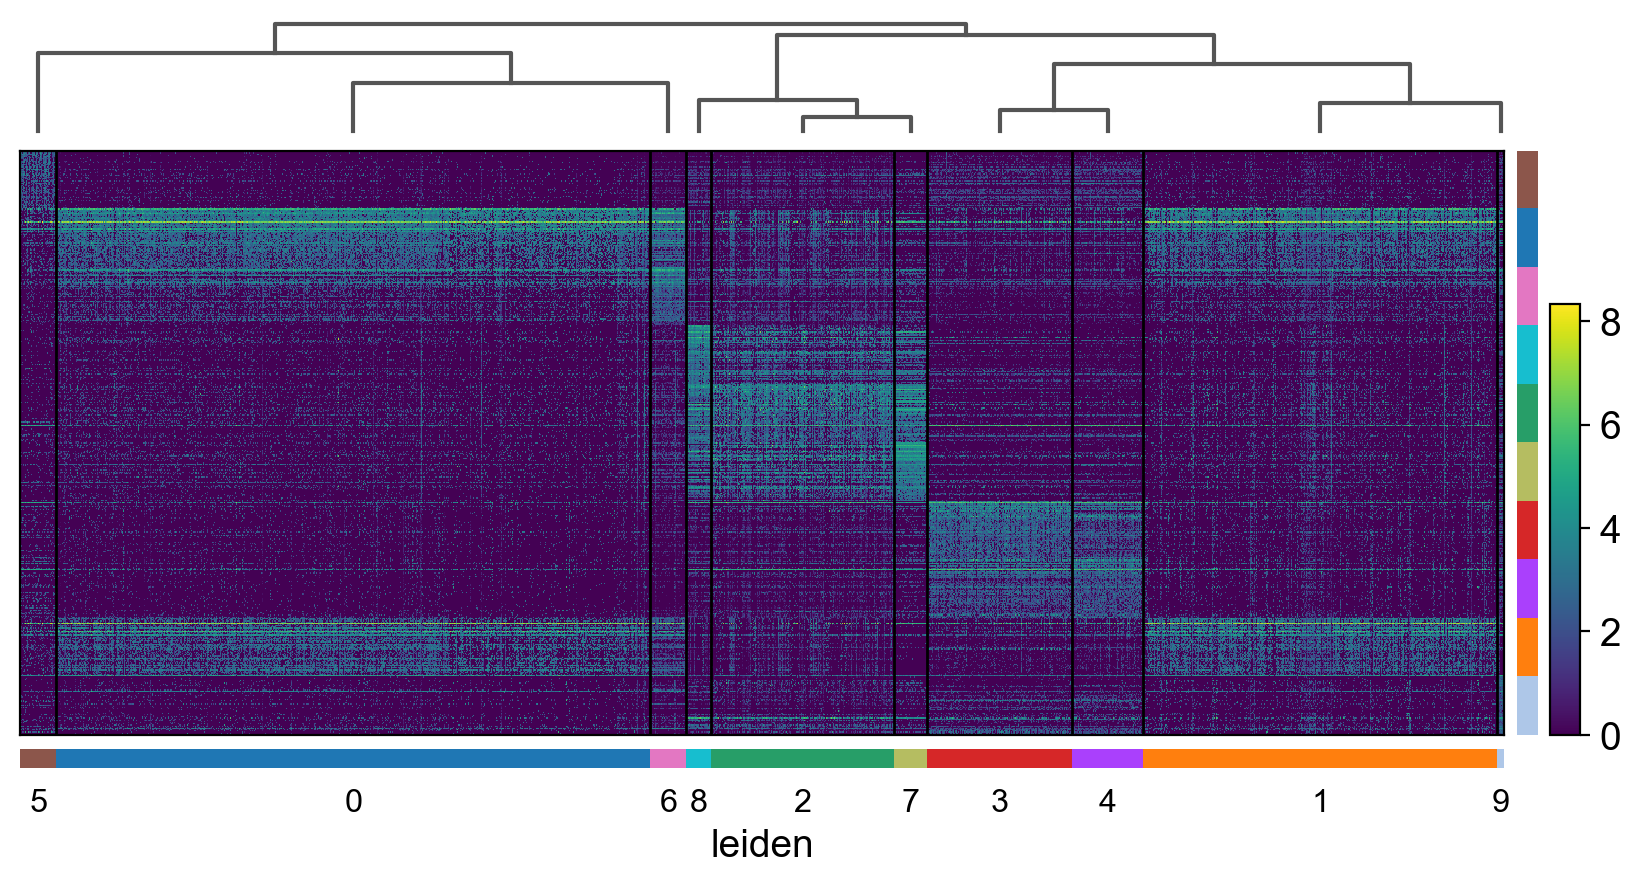

In [380]:
sc.tl.dendrogram(
    adata_neurons, 
    groupby = "leiden", 
    use_rep = "X_pca"
)
sc.pl.rank_genes_groups_heatmap(adata_neurons, groupby='leiden', swap_axes=True, n_genes=50, show_gene_labels=False, cmap='viridis')